![](https://miro.medium.com/max/691/0*xXUYOs5MWWenxoNz)

In [1]:
# необходимые импорты
import cv2

import monai
import numpy as np
import os
import random
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dataset
import torchvision.transforms as transforms

from monai.transforms import (
    EnsureChannelFirst,
    Resize,
    Compose,
    LoadImage,
    NormalizeIntensity,
    RandRotate,
    RandZoom,
    ToTensor
)
from torch import tensor 
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchmetrics import Precision, Recall, F1Score, Accuracy, ConfusionMatrix
from torchvision import models

In [2]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed()

Random seed set as 42


In [3]:
# определим функцию, которая будет вычислять точность модели на итерации
def calculate_accuracy(y_pred, y):

    # находим количество верных совпадений лейбла и выходного класса по каждому примеру в батче
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()

    # посчитаем точность, которая равна отношению количества верных совпадений к общему числу примеров в батче
    acc = correct.float() / y.shape[0]
    return acc

In [4]:
# функция, отвечающая за обучение сети на одной эпохе
def train(model, dataloader, optimizer, loss_function, device):
    # определим значения точности и потерь на старте эпохи
    epoch_acc = 0
    epoch_loss = 0

    # переведем модель в режим тренировки
    model.train()

    # для каждого батча в даталоадере
    for (images, labels) in dataloader:

        # отправляем изображения и метки на устройство
        images = images.to(device)
        labels = labels.to(device)

        # обнуляем градиенты
        optimizer.zero_grad()

        # вычислим выходы сети на данном батче
        predicts = model(images)

        # вычислим величину потерь на данном батче
        loss    = loss_function(predicts, labels)

        # вычислим точность на данном батче
        acc     = calculate_accuracy(predicts, labels)

        # вычислим значения градиентов на батче
        loss.backward()

        # корректируем веса
        optimizer.step()

        # прибавим значения потерь и точности на батче 
        epoch_loss += loss.item()
        epoch_acc  += acc.item()

    # возвращаем величину потерь и точность на эпохе
    return epoch_loss / len(dataloader),  epoch_acc / len(dataloader)


In [5]:
# функция, отвечающая за проверку модели на одной эпохе
def evaluate(model, dataloader, loss_function, device):
    
    # определим начальные величины потерь и точности
    epoch_acc = 0
    epoch_loss = 0

    # переведем модель в режим валидации
    model.eval()

    # указываем, что градиенты вычислять не нужно
    with torch.no_grad():
      
        # для каждого батча в даталоадере
        for images, labels in dataloader:

            # переносим изображения и лейблы на устройство
            images = images.to(device)
            labels = labels.to(device)

            # вычислим выходы сети на батче
            predicts = model(images)

            # вычислим величину потерь на батче
            loss = loss_function(predicts, labels)

            # вычислим точность на батче
            acc  = calculate_accuracy(predicts, labels)


            # прибавим значения потерь и точности на батче к общему
            epoch_loss += loss.item()
            epoch_acc  += acc.item()

      
    # возвращаем величину потерь и точность на эпохе
    return epoch_loss / len(dataloader),  epoch_acc / len(dataloader)

       
        


In [6]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [7]:
# определим устройство, на котором будет идти обучение
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
device

device(type='cuda')

In [8]:
# определим объект трансформации изображений

transform = transforms.Compose([
      transforms.RandomRotation(degrees=10),
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.RandomVerticalFlip(p=0.5),
      transforms.Resize(size=(224, 224)),
      #transforms.RandomResizedCrop(size=(1024, 1024), scale=(0.8, 1.2)),
      transforms.ColorJitter(brightness=0.2, contrast=0.2, ),
      transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
      transforms.ElasticTransform(sigma=12.0),
      transforms.ToTensor()
])

no_aug_transform = transforms.Compose(
      [
            transforms.Resize(size=(224, 224)),
            transforms.ToTensor(),
      ]
)



# aug_transforms = Compose([
#       LoadImage(image_only=True),
#       EnsureChannelFirst(),
#       Resize(spatial_size=(224, 224)),
#       NormalizeIntensity(),
#       RandRotate(mode="bilinear", range_x=0.26, prob=0.5),
#       RandZoom(mode="bilinear"),
#       ToTensor(),
# ])

# no_aug_transforms = Compose([
#       LoadImage(),
#       EnsureChannelFirst(),
#       Resize(spatial_size=(224, 224)),
#       NormalizeIntensity(),
#       ToTensor(),
# ])

In [9]:
def get_images_list_recursive(path_to_subset: str) -> list[dict[str, int]]:
    images_list = []
    for root, dirs, files in os.walk(path_to_subset):
        for file in files:
            abs_path_to_image = os.path.abspath(os.path.join(root, file))
            class_of_image = 0 if os.path.split(os.path.dirname(abs_path_to_image))[-1] == "Glaucoma_Negative" else 1
            images_list.append({"image": abs_path_to_image, "class": class_of_image})
    return images_list

class GlaucomaDataset(monai.data.Dataset):
    def __init__(self, path_to_subset, transforms):
        self.images_list = get_images_list_recursive(path_to_subset)
        self.transforms = transforms
        self.classes = set([item["class"] for item in self.images_list])
        
    def __len__(self):
        return len(self.images_list)
    
    def __getitem__(self, index):
        return self.transforms(self.images_list[index]["image"]), self.images_list[index]["class"]

In [10]:
train_path = r"E:\Datasets\Glaucoma_detection\Fundus_Train_Val_Data\Fundus_Scanes_Sorted_And_Cropped\Train"
test_path  = r"E:\Datasets\Glaucoma_detection\Fundus_Train_Val_Data\Fundus_Scanes_Sorted_And_Cropped\Validation"

train_data = GlaucomaDataset(train_path, transform)
test_data = GlaucomaDataset(test_path, no_aug_transform)
    
print(type(train_data))
print(type(test_data))

print(train_data.classes)
print(test_data.classes)

<class '__main__.GlaucomaDataset'>
<class '__main__.GlaucomaDataset'>
{0, 1}
{0, 1}


In [ ]:
train_data_images_list = train_data.images_list
total_train_samples = len(train_data_images_list)

train_classes_count = {"glaucoma_negative": 0, "glaucoma_positive": 0}
train_classes = []
for image_item in train_data_images_list:
    if image_item["class"] == 0:
        train_classes_count["glaucoma_negative"] += 1
    else:
        train_classes_count["glaucoma_positive"] += 1
    train_classes.append(image_item["class"])
        
classes_weights = [total_train_samples / (len(train_classes_count) * count) for count in train_classes_count.values()]
classes_weights = torch.tensor(classes_weights)
samples_weights = classes_weights[train_classes]

train_sampler = WeightedRandomSampler(samples_weights, num_samples=len(samples_weights), replacement=True)

train_data_ = dataset.ImageFolder(train_path, transform)
test_data_ = dataset.ImageFolder(test_path, no_aug_transform)

train_loader_1 = DataLoader(train_data, batch_size=2, shuffle=True)
test_loader_1  = DataLoader(test_data, batch_size=2, shuffle=False)

NameError: name 'aug_transforms' is not defined

In [ ]:
# инициализируем предобученную модель EfficientNet-B0
efficientnetb0= models.efficientnet_b0(pretrained=False, num_classes=2)
#efficientnetb0_final_linear_in_features = efficientnetb0.classifier[1].in_features

# заменим последний слой классификатора на новый
#efficientnetb0.classifier[1]= nn.Linear(efficientnetb0_final_linear_in_features, 2)


# перенесем модель на устройство
efficientnetb0.to(device)

# выведем модель
print(efficientnetb0)

c:\Users\Reutov\anaconda3\envs\experimental_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Reutov\anaconda3\envs\experimental_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
epochs = 150
optimizer = optim.Adam(efficientnetb0.parameters(), lr=0.001, weight_decay=0.001)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
loss_function = nn.CrossEntropyLoss()

In [ ]:
# попробуем обучить!

best_loss = 1000000
best_test_acc = 0
for epoch in range(epochs):
    
    train_loss, train_acc = train(efficientnetb0, train_loader_1, optimizer, loss_function, device)

    test_loss, test_acc   = evaluate(efficientnetb0, test_loader_1, loss_function, device)

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {test_loss:.3f} |  Val. Acc: {test_acc*100:.2f}%')

    if best_test_acc < test_acc:
        best_test_acc = test_acc
        torch.save(efficientnetb0, "../../src/weights/classification/pytorch/efficientnetb0_best_checkpoint.pth")
    
    
    

Epoch: 01
	Train Loss: 2.848 | Train Acc: 60.77%
	 Val. Loss: 0.829 |  Val. Acc: 60.00%
Epoch: 02
	Train Loss: 0.940 | Train Acc: 62.31%
	 Val. Loss: 0.679 |  Val. Acc: 67.69%
Epoch: 03
	Train Loss: 0.783 | Train Acc: 64.81%
	 Val. Loss: 0.603 |  Val. Acc: 69.23%
Epoch: 04
	Train Loss: 0.656 | Train Acc: 69.23%
	 Val. Loss: 0.647 |  Val. Acc: 73.85%
Epoch: 05
	Train Loss: 0.688 | Train Acc: 69.04%
	 Val. Loss: 0.622 |  Val. Acc: 73.08%
Epoch: 06
	Train Loss: 0.623 | Train Acc: 71.54%
	 Val. Loss: 0.612 |  Val. Acc: 73.85%
Epoch: 07
	Train Loss: 0.643 | Train Acc: 70.58%
	 Val. Loss: 0.588 |  Val. Acc: 73.85%
Epoch: 08
	Train Loss: 0.640 | Train Acc: 71.35%
	 Val. Loss: 1.676 |  Val. Acc: 46.92%
Epoch: 09
	Train Loss: 0.644 | Train Acc: 69.81%
	 Val. Loss: 0.592 |  Val. Acc: 73.85%
Epoch: 10
	Train Loss: 0.681 | Train Acc: 66.35%
	 Val. Loss: 0.574 |  Val. Acc: 73.85%
Epoch: 11
	Train Loss: 0.640 | Train Acc: 70.19%
	 Val. Loss: 0.569 |  Val. Acc: 73.85%
Epoch: 12
	Train Loss: 0.619 | T

In [ ]:
state_dict = torch.load(r"..\..\src\weights\classification\pytorch\efficientnetb0_best_checkpoint.pth", map_location=device).state_dict()
inference_model = models.efficientnet_b0(num_classes=2, pretrained=False)
inference_model.load_state_dict(state_dict)
inference_model.eval()
inference_model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
with torch.no_grad():
    true_classified_count = 0
    total_count = 0
    labels_list = []
    preds_list = []
    for i, item in enumerate(test_data):
        total_count += 1
        image = item[0].unsqueeze(0).to(device)
        class_id = item[1]
        labels_list.append(class_id)
        outputs = inference_model(image)
        predicted_id = outputs.argmax()
        preds_list.append(predicted_id)
        print(f"Исходный идентификатор класса: {class_id}, предсказанный идентификатор класса: {predicted_id.item()}")
        
        if class_id == predicted_id.item():
            true_classified_count += 1
        else:
            item_ = transforms.Resize((1024, 1024), interpolation=0)(item[0])
            image_array = item_.cpu().numpy()
            image_array = cv2.cvtColor(image_array.transpose(1, 2, 0), cv2.COLOR_RGB2BGR)
            image_array = image_array * 255
            image_array = image_array.astype("uint8")
            #image_array = cv2.resize(image_array, (640, 480))
            #image_name = f"label_{test_data.classes[class_id]}__predicted_{test_data.classes[predicted_id]}_{i}.jpg"
            #cv2.imwrite(os.path.join(path_to_save_images_with_errors, image_name), image_array)
            
    
    

Исходный идентификатор класса: 0, предсказанный идентификатор класса: 0
Исходный идентификатор класса: 0, предсказанный идентификатор класса: 0
Исходный идентификатор класса: 0, предсказанный идентификатор класса: 0
Исходный идентификатор класса: 0, предсказанный идентификатор класса: 0
Исходный идентификатор класса: 0, предсказанный идентификатор класса: 0
Исходный идентификатор класса: 0, предсказанный идентификатор класса: 0
Исходный идентификатор класса: 0, предсказанный идентификатор класса: 0
Исходный идентификатор класса: 0, предсказанный идентификатор класса: 1
Исходный идентификатор класса: 0, предсказанный идентификатор класса: 1
Исходный идентификатор класса: 0, предсказанный идентификатор класса: 0
Исходный идентификатор класса: 0, предсказанный идентификатор класса: 0
Исходный идентификатор класса: 0, предсказанный идентификатор класса: 0
Исходный идентификатор класса: 0, предсказанный идентификатор класса: 1
Исходный идентификатор класса: 0, предсказанный идентификатор кл

In [ ]:
evaluate(inference_model, test_loader_1, loss_function, device)

(0.5854994523983735, 0.7692307692307693)

In [ ]:


preds = tensor(preds_list)
targets = tensor(labels_list)

precision = Precision(task="binary", average="macro", num_classes=2)
recall = Recall(task="binary", average="macro", num_classes=2)
f1_score = F1Score(task="binary", average="macro", num_classes=2)
accuracy = Accuracy(task="binary", average="macro", num_classes=2)

print(f"Precision: {precision(preds, targets).item()}")
print(f"Recall: {recall(preds, targets).item()}")
print(f"F1 Score: {f1_score(preds, targets).item()}")
print(f"Accuracy: {accuracy(preds, targets).item()}")

Precision: 0.5666666626930237
Recall: 0.5
F1 Score: 0.53125
Accuracy: 0.7692307829856873


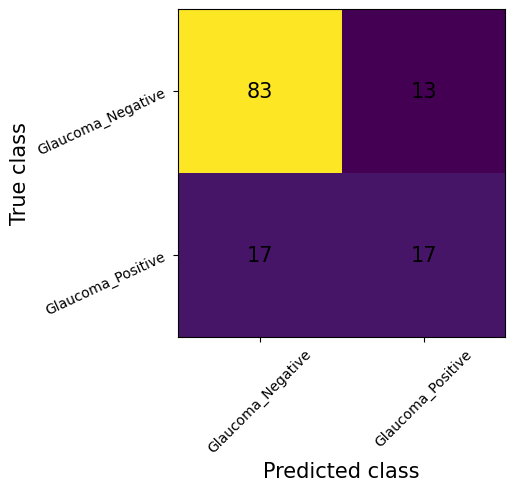

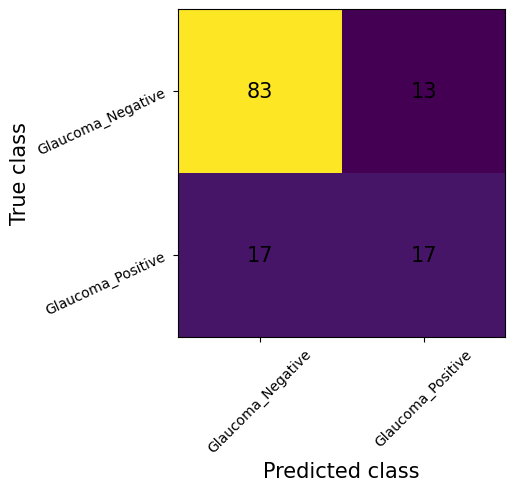

In [ ]:
confusion_matrix = ConfusionMatrix(task="binary", num_classes=2)
confusion_matrix.update(preds, targets)
fig, axes = confusion_matrix.plot()
axes.xaxis.set_ticklabels(["Glaucoma_Negative", "Glaucoma_Positive"])
axes.yaxis.set_ticklabels(["Glaucoma_Negative", "Glaucoma_Positive"])
fig